In [ ]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score, log_loss, confusion_matrix
from sklearn.neural_network import MLPClassifier

from scipy.stats import randint as sp_randint

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *

In [3]:
# Load the pre-split data

store = pd.HDFStore('/home/dissertation/data/dfs_abt_split.h5')
X_train = store['X_train']
X_test = store['X_test']
y_train = store['y_train']
y_test = store['y_test']
store.close()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head()

(600803, 165) (600803,)
(257487, 165) (257487,)


,bd,registration_init_time,city,gender,registered_via,SUM(transactions.payment_plan_days),SUM(transactions.plan_list_price),SUM(transactions.actual_amount_paid),SUM(transactions.transaction_date),SUM(transactions.membership_expire_date),...,DIFF(MAX(transactions.planned_daily_price)),DIFF(MAX(transactions.daily_price)),DIFF(STD(transactions.payment_plan_days)),DIFF(STD(transactions.plan_list_price)),DIFF(STD(transactions.actual_amount_paid)),DIFF(STD(transactions.transaction_date)),DIFF(STD(transactions.membership_expire_date)),DIFF(STD(transactions.price_difference)),DIFF(STD(transactions.planned_daily_price)),DIFF(STD(transactions.daily_price))
551174,28,20131223,5,male,3,180,298.00,894.00,120923653,120924153,...,1.67,1.67,0.00,76.94,0.00,3890.64,3353.08,55.25,2.56,0.00
403333,20,20131223,13,male,3,127,627.00,627.00,100812365,100812869,...,1.03,1.03,9.96,42.15,71.37,-1967.03,-2345.67,-20.98,1.41,2.33
594889,18,20131227,13,male,3,540,2682.00,2682.00,362862440,362881912,...,0.00,0.00,0.00,-29.22,0.00,-371.25,-554.29,-20.98,-0.97,0.00
100379,0,20140109,1,unknown,7,547,2384.00,2682.00,382888820,383039868,...,0.00,0.00,4.90,21.64,34.18,-2480.05,344.36,9.19,0.73,1.08
207602,35,20140125,13,female,7,720,2529.00,2956.00,483713706,483807163,...,0.00,0.00,0.00,44.20,19.09,-1495.13,-544.06,38.55,1.47,0.64


In [14]:
X_train.columns[5:25]

Index(['SUM(transactions.payment_plan_days)',
       'SUM(transactions.plan_list_price)',
       'SUM(transactions.actual_amount_paid)',
       'SUM(transactions.transaction_date)',
       'SUM(transactions.membership_expire_date)',
       'SUM(transactions.price_difference)',
       'SUM(transactions.planned_daily_price)',
       'SUM(transactions.daily_price)', 'ALL(transactions.is_auto_renew)',
       'ALL(transactions.is_cancel)', 'MODE(transactions.payment_method_id)',
       'NUM_UNIQUE(transactions.payment_method_id)',
       'MIN(transactions.payment_plan_days)',
       'MIN(transactions.plan_list_price)',
       'MIN(transactions.actual_amount_paid)',
       'MIN(transactions.transaction_date)',
       'MIN(transactions.membership_expire_date)',
       'MIN(transactions.price_difference)',
       'MIN(transactions.planned_daily_price)',
       'MIN(transactions.daily_price)'],
      dtype='object')

In [ ]:
# ## TEMP TEMP TEMP ##
# for col in X_train.head().filter(regex='daily').columns:
#     X_train.drop(col, axis=1, inplace=True)
#     X_test.drop(col, axis=1, inplace=True)

In [4]:
import sklearn 
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
## WHAT METRIC SHOULD BE OPTIMSED AS PART OF CV

In [6]:
RANDOM_STATE = 42 
CV_ITER = 3
SCORING_METRIC = 'recall'

## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]
classifiers = [
    ('NB', GaussianNB(), {}, SCORING_METRIC),
    ('DT', DecisionTreeClassifier(), {}, SCORING_METRIC),
    ('RF', RandomForestClassifier(n_jobs =-1), {}, SCORING_METRIC),
    ('LR', LogisticRegression(solver = 'liblinear'), {}, SCORING_METRIC),
    ('AB', AdaBoostClassifier(), {}, SCORING_METRIC),
    ('MLP', MLPClassifier(), {}, SCORING_METRIC),
]

In [7]:
cat_col= ['gender', 'city', 'registered_via']

In [8]:
all_metrics = pd.DataFrame()
all_metrics

""


### Experiment 1.1 Baseline - Default Settings - No sampling

Model Build Iteration 0
PRE-SAMPLING: (600803, 165) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (600803, 165) (600803,) Counter({0: 544661, 1: 56142})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['gender', 'city', 'registered_via']
Categorical columns in dataset ['gender', 'city', 'registered_via']
X_train:  (600803, 188) (600803, 1)
X_test:  (257487, 188) (257487, 1)


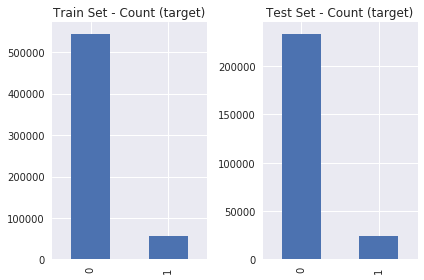

Building NB classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric
Building DT classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric
Building RF classifier
No params set, using Standard training


/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Performing 3-fold CV on test set using recall metric
Building LR classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric
Building AB classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric
Building MLP classifier
No params set, using Standard training
Performing 3-fold CV on test set using recall metric


/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


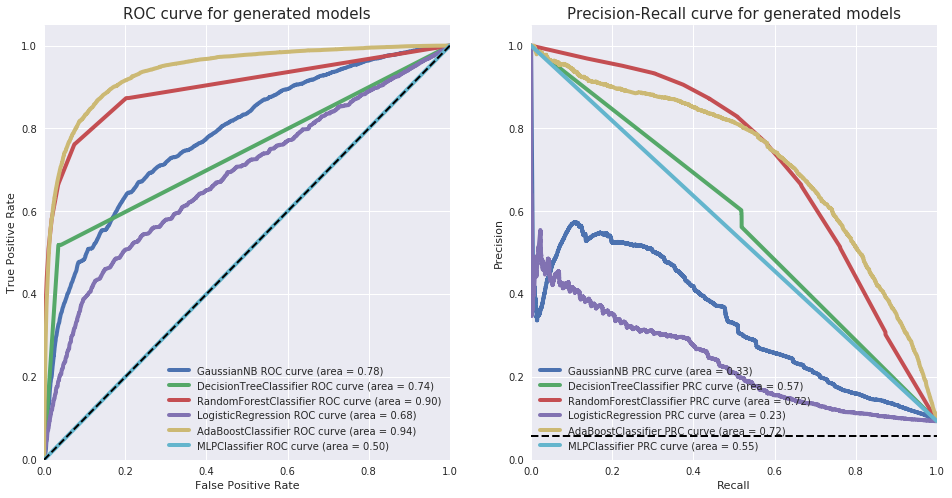

CPU times: user 4h 17min 41s, sys: 16min 20s, total: 4h 34min 1s
Wall time: 4h 27min 15s


In [9]:
%%time
sampler = ('None', DummySampler())

exp_metrics = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, 
                                 RANDOM_STATE, cv_iter=CV_ITER, cat_col = cat_col)

all_metrics = all_metrics.append(exp_metrics)

In [1]:
all_metrics

NameError: name 'all_metrics' is not defined

### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

In [ ]:
%%time
sampler = ('ROS 1:1', RandomOverSampler(random_state=RANDOM_STATE))

exp_metrics = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, 
                                 RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city', 'registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.3 Baseline - Default Settings - Undersampled training set

In [ ]:
sampler = ('RUS 1:1', RandomUnderSampler(random_state=RANDOM_STATE))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
sampler = ('ROS 3:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/3))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
sampler = ('ROS 2:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/2))

exp_metrics = perform_experiment(base_dataset, classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

### Experiment 1.7 Baseline Default Settings SMOTE-NC

In [ ]:
sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,3,4,5,6,7,8,13,14], n_jobs=8))

## Keep the following, essentially dropping the dt columns
cols = ['is_churn', 'city', 'gender', 'age_cat', 'registered_via', 'total_order',
       'payment_method_id_mode', 'payment_method_id_count',
       'payment_plan_days_mode', 'payment_plan_days_mean',
       'plan_list_price_mean', 'plan_lifetime_value', 'actual_amount_mean',
       'total_actual_amount', 'is_auto_renew_mode', 'cancel_times','transaction_date_delta']

exp_metrics = perform_experiment(base_dataset[cols], classifiers, sampler, 1, RANDOM_STATE, cv_iter=CV_ITER, cat_col = ['city','registered_via', 'gender'])

all_metrics = all_metrics.append(exp_metrics)

In [ ]:
all_metrics.sort_values('model_churn_cost', ascending=True)

In [ ]:
## Just try an SVM 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
model_train_results = train_model(base_dataset, sampling_method = 'under', classifiers = [('SGDClassifier', SGDClassifier(loss='log'))])

In [ ]:
## Print the feature importance 

feature_index = np.flip(np.argsort(model.feature_importances_), axis=0)
ordered_features = []
column_names = X_test.columns

for i in feature_index[0:10]:
    print(np.round(model.feature_importances_[i], 3), ' --> ', column_names[i])
    ordered_features.append(column_names[i])

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)